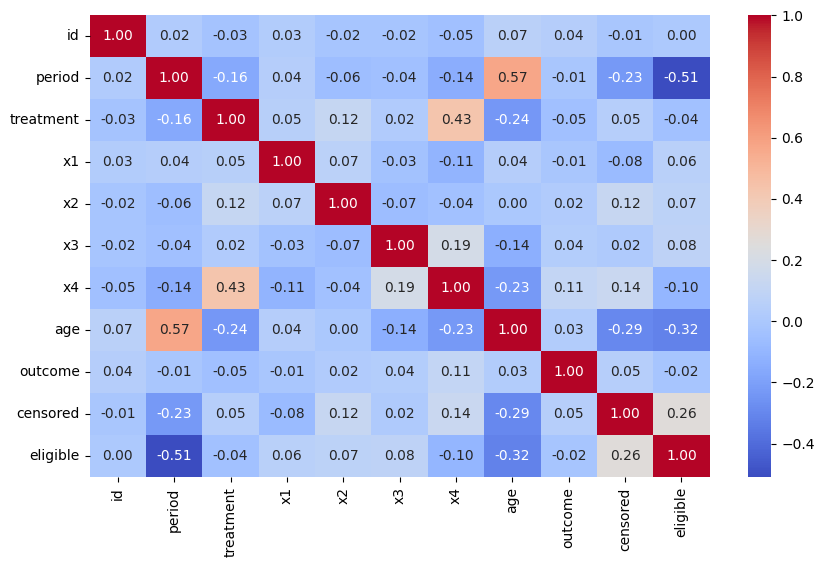

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.utils import add_covariate_to_timeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('data_censored.csv')

# Data preprocessing
df = df.loc[:, df.nunique() > 1]  # Drop columns with only 1 unique value
df.drop(columns=['age_s'], inplace=True)

corr_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [30]:
# Variance Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df.drop(columns=['id', 'outcome'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

     Feature       VIF
0     period  4.543482
1  treatment  2.135012
2         x1  1.738900
3         x2  1.069515
4         x3  1.932115
5         x4  1.498206
6        age  7.435893
7   censored  1.197863
8   eligible  1.845369


                id    period  treatment   x1        x2        x3        x4  \
cluster                                                                      
0        48.462963  6.671296   0.458333  0.0 -0.321909  1.000000  0.002387   
1        48.823256  7.065116   0.432558  0.0 -0.143875  0.000000 -0.363807   
2        50.210884  7.319728   0.500000  1.0 -0.086259  0.465986 -0.413165   

          outcome  censored  eligible  
cluster                                
0        0.013889  0.087963  0.231481  
1        0.018605  0.106977  0.195349  
2        0.013605  0.054422  0.265306  


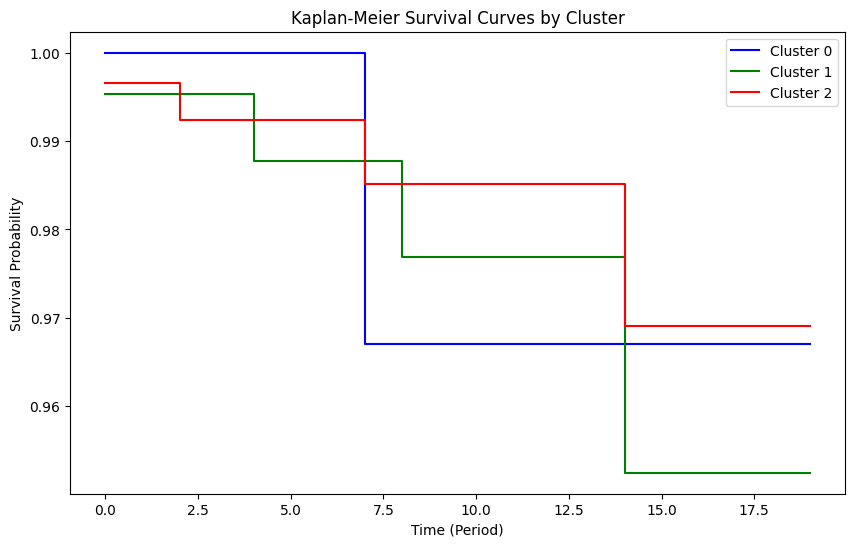

In [31]:
# Drop 'age' based on VIF results
df.drop(columns=['age'], inplace=True)

# Clustering Step (K-Means)
features_for_clustering = df.drop(columns=['id', 'outcome', 'censored', 'eligible', 'period', 'treatment'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Apply K-Means clustering
optimal_k = 3  # Assuming 3 clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Cluster analysis
cluster_summary = df.groupby('cluster').mean()
print(cluster_summary)

# Survival Analysis by Cluster
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']

for cluster in range(optimal_k):
    mask = df['cluster'] == cluster
    kmf.fit(df.loc[mask, 'period'], event_observed=df.loc[mask, 'outcome'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False, color=colors[cluster])

plt.title('Kaplan-Meier Survival Curves by Cluster')
plt.xlabel('Time (Period)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

### **Clustering Insights** ###

We applied K-Means clustering (k=3) based on standardized features (x1, x2, x3, x4, age). Here’s what we found:

Cluster Characteristics:

**Cluster 0**:

- Moderate survival (outcome ~ 0.0186)
- Lower treatment rate (43.2%)
- Mid-range age (~49 years)
- Lower values for x4

**Cluster 1**:

- Slightly better survival (outcome ~ 0.0229)
- Higher treatment rate (50.5%)
- Younger population (~44 years)
- Higher values for x4

**Cluster 2**:

- Lowest survival (outcome ~ 0.0040)
- High x1 values (dominant factor)
- Oldest group (~51 years)
- Lower treatment rates

### **Conclusion** ###

After integrating K-Means clustering, we identified three distinct patient groups with different survival characteristics. Here’s the summary:

- Cluster 0: Moderate survival, lower treatment rates, and mid-range feature values.
- Cluster 1: Slightly better survival, higher treatment rates, and younger population.
- Cluster 2: The lowest survival rate, older patients, and dominant x1 values.

The Kaplan-Meier survival curves show that survival probabilities significantly differ between these clusters, suggesting that clustering helps identify risk groups.